#1.0 - Importando Bbliotecas

1.0 - Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime as dt

In [ ]:
plt.rcParams['figure.figsize'] = (18, 8)

#2.0 - Criando Funções

2.0 - Creating Functions

In [ ]:
def busca_titulos_tesouro_direto():
  url = 'https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv'
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Data Vencimento'] = pd.to_datetime(df['Data Vencimento'], dayfirst=True)
  df['Data Base']       = pd.to_datetime(df['Data Base'], dayfirst=True)
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :3])
  df = df.set_index(multi_indice).iloc[: , 3:]  
  return df

In [ ]:
def consulta_bcb(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst = True)
  df.set_index('data', inplace = True)
  return df

#3.0 - Dados das Instituições

3.0 - Institutional Data

##3.1 - Tesouro Direto

3.1 - Brazilian Nacional treasure

In [ ]:
titulos = busca_titulos_tesouro_direto()
titulos.sort_index(inplace=True)

In [ ]:
tipos_titulos = titulos.index.droplevel(level=1).droplevel(level=1).drop_duplicates().to_list()
tipos_titulos

['Tesouro IGPM+ com Juros Semestrais',
 'Tesouro IPCA+',
 'Tesouro IPCA+ com Juros Semestrais',
 'Tesouro Prefixado',
 'Tesouro Prefixado com Juros Semestrais',
 'Tesouro Selic']

##3.2 - Banco Central do Brasil (BCB)

3.2 - Brazilian Central Bank

###A) SELIC

A) Basic interest rate

In [ ]:
selic_meta = consulta_bcb(432)

In [ ]:
selic_meta.rename(columns = {'valor': 'selic_ano'}, inplace = True)

###B) Índice de Preços ao Consumidor Amplo (IPCA)

B) Inflation rate released at the end of the month

In [ ]:
ipca = consulta_bcb(433)
ipca.reset_index(inplace = True)

In [ ]:
ipca['valor12'] = 1 + ipca['valor']/100

In [ ]:
ipca['12meses_ipca'] = ''

for i in range(0, ipca.shape[0]-11):
  ipca.loc[i+11, '12meses_ipca'] = ((ipca.loc[i, 'valor12'] * 
                                     ipca.loc[i+1, 'valor12'] * 
                                     ipca.loc[i+2, 'valor12'] * 
                                     ipca.loc[i+3, 'valor12'] * 
                                     ipca.loc[i+4, 'valor12'] * 
                                     ipca.loc[i+5, 'valor12'] * 
                                     ipca.loc[i+6, 'valor12'] * 
                                     ipca.loc[i+7, 'valor12'] * 
                                     ipca.loc[i+8, 'valor12'] * 
                                     ipca.loc[i+9, 'valor12'] * 
                                     ipca.loc[i+10, 'valor12'] * 
                                     ipca.loc[i+11, 'valor12']) - 1) * 100

In [ ]:
ipca = ipca[ipca.index >= 11]
ipca.reset_index(inplace = True)
ipca['12meses_ipca'] = ipca['12meses_ipca'].astype('float64')
ipca.drop(columns = ['index', 'valor', 'valor12'], axis = 1, inplace = True)
#ipca.set_index('data', inplace = True)

##3.3 - Instituto Brasileiro de Geografia e Estatística (IBGE)

3.3 - Brazilian Institute of Geography and Statistics

###A) Índice de Preços ao Consumidor Amplo - 15 (IPCA-15)

A) Inflation rate released in the middle of the month

In [ ]:
url = 'https://servicodados.ibge.gov.br/api/v3/agregados/3065/periodos/200005|200006|200007|200008|200009|200010|200011|200012|200101|200102|200103|200104|200105|200106|200107|200108|200109|200110|200111|200112|200201|200202|200203|200204|200205|200206|200207|200208|200209|200210|200211|200212|200301|200302|200303|200304|200305|200306|200307|200308|200309|200310|200311|200312|200401|200402|200403|200404|200405|200406|200407|200408|200409|200410|200411|200412|200501|200502|200503|200504|200505|200506|200507|200508|200509|200510|200511|200512|200601|200602|200603|200604|200605|200606|200607|200608|200609|200610|200611|200612|200701|200702|200703|200704|200705|200706|200707|200708|200709|200710|200711|200712|200801|200802|200803|200804|200805|200806|200807|200808|200809|200810|200811|200812|200901|200902|200903|200904|200905|200906|200907|200908|200909|200910|200911|200912|201001|201002|201003|201004|201005|201006|201007|201008|201009|201010|201011|201012|201101|201102|201103|201104|201105|201106|201107|201108|201109|201110|201111|201112|201201|201202|201203|201204|201205|201206|201207|201208|201209|201210|201211|201212|201301|201302|201303|201304|201305|201306|201307|201308|201309|201310|201311|201312|201401|201402|201403|201404|201405|201406|201407|201408|201409|201410|201411|201412|201501|201502|201503|201504|201505|201506|201507|201508|201509|201510|201511|201512|201601|201602|201603|201604|201605|201606|201607|201608|201609|201610|201611|201612|201701|201702|201703|201704|201705|201706|201707|201708|201709|201710|201711|201712|201801|201802|201803|201804|201805|201806|201807|201808|201809|201810|201811|201812|201901|201902|201903|201904|201905|201906|201907|201908|201909|201910|201911|201912|202001|202002|202003|202004|202005|202006|202007|202008|202009|202010|202011|202012|202101|202102|202103|202104|202105|202106|202107|202108/variaveis/1120?localidades=N1[all]'
ipca15_ibge = requests.get(url).json()

In [ ]:
dict_ipca15_ibge1 = ipca15_ibge[0]
dict_ipca15_ibge2 = dict_ipca15_ibge1["resultados"]
dict_ipca15_ibge3 = dict_ipca15_ibge2[0]
dict_ipca15_ibge4 = dict_ipca15_ibge3['series']
dict_ipca15_ibge5 = dict_ipca15_ibge4[0]
dict_ipca15_ibge6 = dict_ipca15_ibge5['serie']

In [ ]:
df_ipca15_ibge = pd.DataFrame(data = list(dict_ipca15_ibge6.items()), columns=['data', 'valor'])

In [ ]:
df_ipca15_ibge['valor'] = df_ipca15_ibge['valor'].astype(float)

In [ ]:
df_ipca15_ibge['data2'] = ''

for i in range(df_ipca15_ibge.shape[0]):
  df_ipca15_ibge.loc[i, 'data2'] = df_ipca15_ibge.loc[i, 'data'][:4] + '-' + df_ipca15_ibge.loc[i, 'data'][4:] + '-01' #isso daqui foi só uma macete para dar tudo certo lá embaixo
  #o ipca 15 é divukgado no 15º dia do mês

df_ipca15_ibge['data2'] = pd.to_datetime(df_ipca15_ibge['data2'], yearfirst = True)

In [ ]:
df_ipca15_ibge_anual = df_ipca15_ibge[['data2', 'valor']]
df_ipca15_ibge_anual.rename(columns = {'data2': 'data', 'valor': '12meses_ipca15'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###B) Uma breve análise do IPCA e IPCA15

Como podemos observar, os índices são fortemente correlacionados. Como o IPCA15 é divulgado antes do índice oficial (IPCA), ele funciona como uma proxy, ou uma prévia. Isso quer dizer que, como diversos títulos são indexados ao IPCA, ou fortemente correlacionado a ele, fica bom saber como o índice irá comportar no próximo mês. 

B) A brief analysis of the IPCA and IPCA15

As we can see, the indices are strongly correlated. The IPCA15 is released before the official index (IPCA), it works as a proxy, or a preview. This means that, as several bonds are indexed to, or strongly correlated with, the IPCA, it is good to know how the index will behave in the next month.

In [ ]:
df_ipca15_ibge_anual.index = range(df_ipca15_ibge_anual.shape[0])

In [ ]:
df_ipca15_ibge_anual['macete'] = range(df_ipca15_ibge_anual.shape[0])

In [ ]:
ipca_teste = ipca[ipca.index >= 233]
ipca_teste.reset_index(inplace = True)
ipca_teste = ipca_teste[['12meses_ipca']]
ipca_teste['macete'] = range(ipca_teste.shape[0])

In [ ]:
df_precos = pd.merge(df_ipca15_ibge_anual, ipca_teste, on = 'macete', how = 'left')

In [ ]:
df_precos = df_precos[['data', '12meses_ipca15', '12meses_ipca']]

In [ ]:
df_precos.set_index('data', inplace = True)

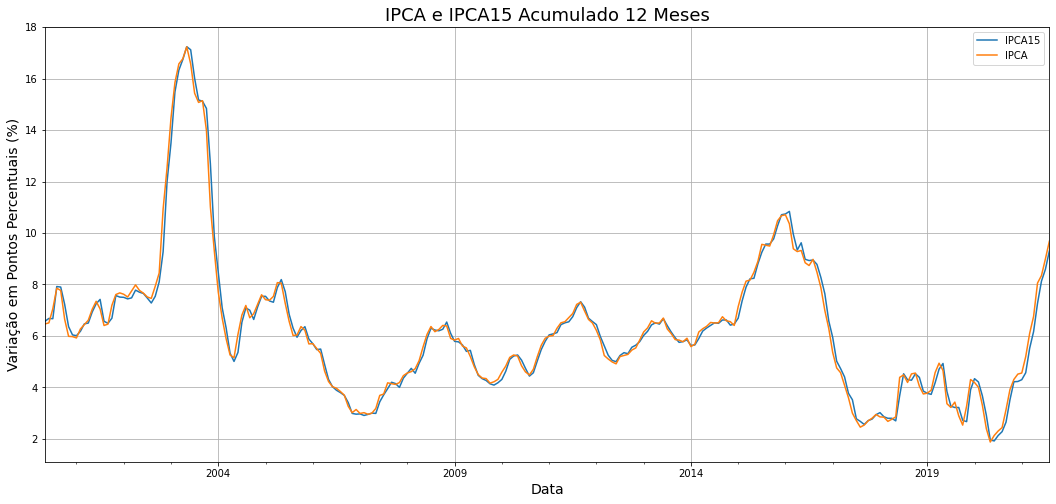

In [ ]:
df_precos['12meses_ipca15'].plot(label = 'IPCA15')
df_precos['12meses_ipca'].plot(label = 'IPCA')
plt.title('IPCA e IPCA15 Acumulado 12 Meses', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais (%)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_precos[['12meses_ipca15', '12meses_ipca']].corr()

,12meses_ipca15,12meses_ipca
12meses_ipca15,1.000000,0.994153
12meses_ipca,0.994153,1.000000


#4.0 - Análise dos Títulos Públicos Pré-fixado 2026 e Tesouro IPCA +2026

Tendo feito todo o carregamento das bases, vamos começar a análise. A escolhe desses dois títulos foi feito com base na sua duração, ambos são de 5 anos, e não pagarem juros semestrais.

4.0 - Analysis of thow bonds: Pré-fixado 2026 and Tesouro IPCA +2026 

After loading the base, let's start our analysis. The choice of these two bonds was made based on their duration, both are 5 years, and do not pay coupons.

##4.1 Pré-fixado 2026

O Título Pré-Fixado 2026 oferece uma taxa fixa de juros, com vencimento em 01/01/2026

4.1 - Pré-fixado 2026 (This bond is not indexed with inflation)

The Pré-Fixado 2026 offers a fixed interest rate, maturing on 01/01/2026 (dd/mm/yyyy)

In [ ]:
pre2026 = titulos.loc[('Tesouro Prefixado', '2026-01-01')]

In [ ]:
ipca.set_index('data', inplace = True)
ipca15 = df_precos[['12meses_ipca15']]

In [ ]:
selic_meta_pre2026 = selic_meta[selic_meta.index >= pre2026.index[0]]
ipca_pre2026 = ipca[ipca.index >= pre2026.index[0]]
ipca15_pre2026 = ipca15[ipca15.index >= pre2026.index[0]]

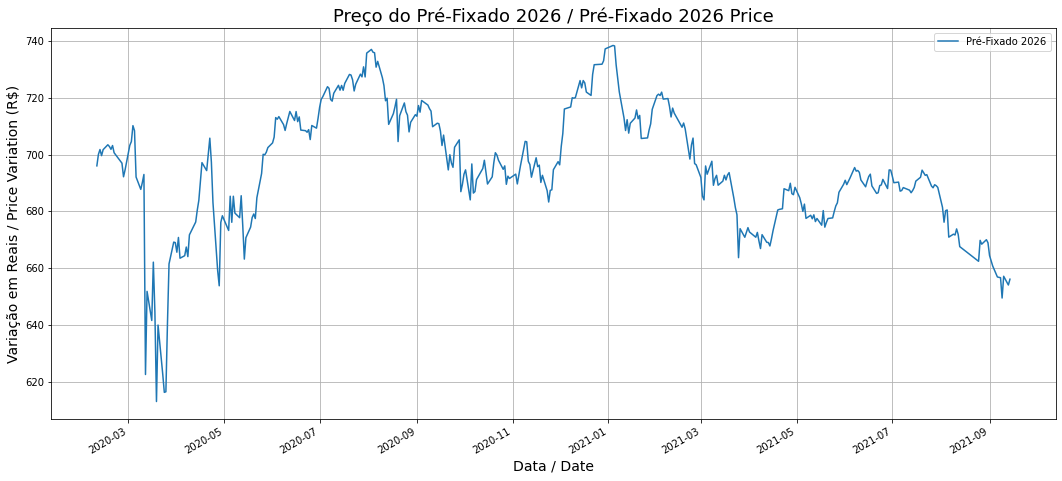

In [ ]:
pre2026['PU Compra Manha'].plot(label = "Pré-Fixado 2026")
plt.title('Preço do Pré-Fixado 2026 / Pré-Fixado 2026 Price', fontsize = 18)
plt.xlabel('Data / Date', fontsize = 14)
plt.ylabel('Variação em Reais / Price Variation (R$)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

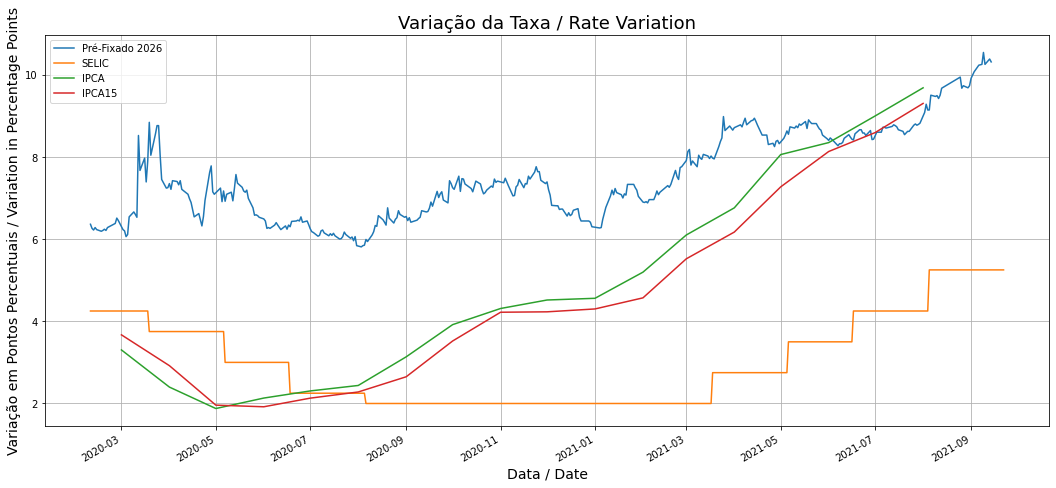

In [ ]:
pre2026['Taxa Compra Manha'].plot(label = "Pré-Fixado 2026");
selic_meta_pre2026['selic_ano'].plot(label = "SELIC");
ipca_pre2026['12meses_ipca'].plot(label = "IPCA");
ipca15_pre2026['12meses_ipca15'].plot(label = "IPCA15");
plt.title('Variação da Taxa / Rate Variation', fontsize = 18)
plt.xlabel('Data / Date', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais / Variation in Percentage Points', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
df = pd.merge(pre2026, selic_meta_pre2026, left_index = True, right_index = True)
df = pd.merge(df, ipca_pre2026, left_index = True, right_index = True)
df = pd.merge(df, ipca15_pre2026, left_index = True, right_index = True)
df[['Taxa Compra Manha', 'selic_ano', '12meses_ipca', '12meses_ipca15']].corr()

,Taxa Compra Manha,selic_ano,12meses_ipca,12meses_ipca15
Taxa Compra Manha,1.000000,0.489734,0.876530,0.897446
selic_ano,0.489734,1.000000,0.401113,0.491610
12meses_ipca,0.876530,0.401113,1.000000,0.992059
12meses_ipca15,0.897446,0.491610,0.992059,1.000000


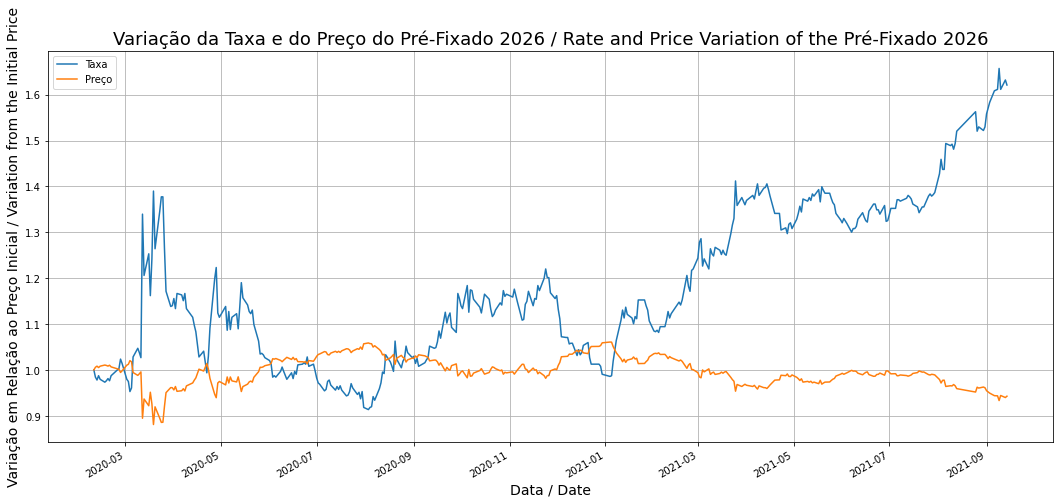

In [ ]:
(pre2026['Taxa Compra Manha'] / pre2026['Taxa Compra Manha'].iloc[0]).plot(label = 'Taxa');
(pre2026['PU Compra Manha'] / pre2026['PU Compra Manha'].iloc[0]).plot(label = 'Preço');
plt.title('Variação da Taxa e do Preço do Pré-Fixado 2026 / Rate and Price Variation of the Pré-Fixado 2026', fontsize = 18)
plt.xlabel('Data / Date', fontsize = 14)
plt.ylabel('Variação em Relação ao Preço Inicial / Variation from the Initial Price', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

Esses 3 gráficos nos mostram o comportamento do Título Pré-Fixado. Podemos observar que a Taxa é muito mais volátil que o preço. Além disso, ainda falando sobre a taxa, observamos pela tabela sua correlação tanto com as taxas de inflação, pelo IPCA e IPCA15. Como ambas mostram um forte crescimento, é de se esperar que a taxa do título continuará a crescer. Para voltar a ter uma taxa real de retorno positivo.

These 3 graphics show us the behavior of the Fixed bond. We can see that the Rate is much more volatile than price. Furthermore, still talking about the rate, we can see in the table its correlation with both the inflation rates, IPCA and IPCA15. As both show strong growth, it is to be expected that the bond rate will continue to grow. To return to have a positive real rate.

##4.2 - Tesouro IPCA+ 2026

O Título Tesouro IPCA+ 2026 oferece uma taxa fixa e variável de juros, de acordo com o IPCA, com vencimento em 15/08/2026

4.2 - Tesouro IPCA+ 2026 (This bond is indexed with inflation)

The IPCA+ 2026 Bond offers a fixed and variable interest rate, according to the IPCA, maturing on 08/15/2026 (dd/mm/yyyy)

In [ ]:
ipca2026 = titulos.loc[('Tesouro IPCA+', '2026-08-15')]

In [ ]:
selic_meta_ipca2026 = selic_meta[selic_meta.index >= ipca2026.index[0]]
ipca_ipca2026 = ipca[ipca.index >= ipca2026.index[0]]
ipca15_ipca2026 = ipca15[ipca15.index >= ipca2026.index[0]]

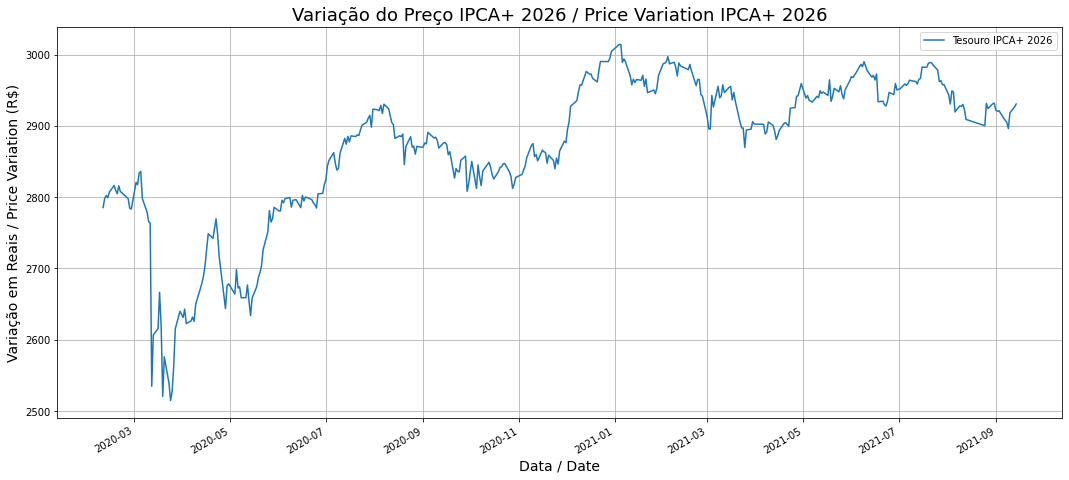

In [ ]:
ipca2026['PU Compra Manha'].plot(label = 'Tesouro IPCA+ 2026')
plt.title('Variação do Preço IPCA+ 2026 / Price Variation IPCA+ 2026', fontsize = 18)
plt.xlabel('Data / Date', fontsize = 14)
plt.ylabel('Variação em Reais / Price Variation (R$)', fontsize = 14)
plt.legend()
plt.grid()
plt.show();

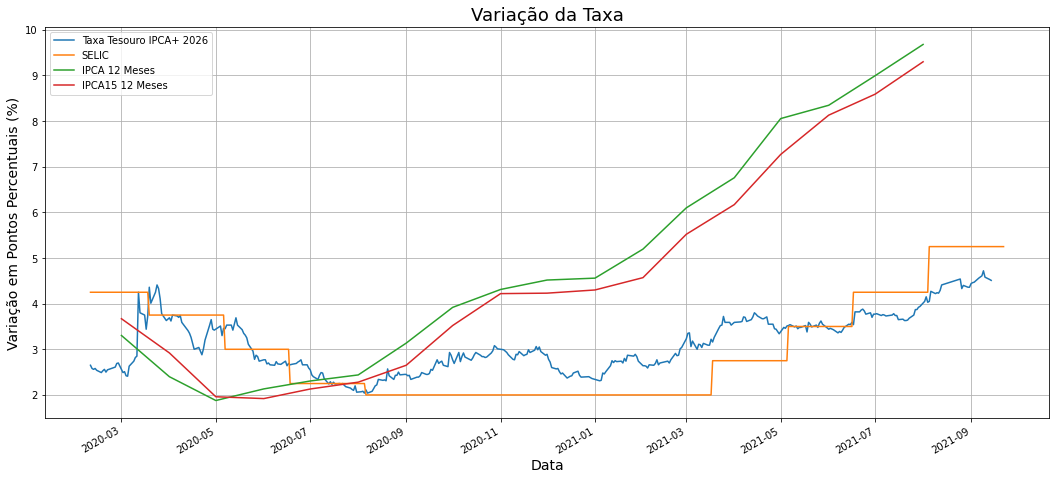

In [ ]:
ipca2026['Taxa Compra Manha'].plot(label = 'Tesouro IPCA+ 2026');
selic_meta_ipca2026['selic_ano'].plot(label = 'SELIC');
ipca_ipca2026['12meses_ipca'].plot(label = 'IPCA 12 Meses');
ipca15_ipca2026['12meses_ipca15'].plot(label = 'IPCA15 12 Meses');
plt.title('Variação da Taxa', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais (%)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
df = pd.merge(ipca2026, selic_meta_ipca2026, left_index = True, right_index = True)
df = pd.merge(df, ipca_ipca2026, left_index = True, right_index = True)
df = pd.merge(df, ipca15_ipca2026, left_index = True, right_index = True)
df[['Taxa Compra Manha', 'selic_ano', '12meses_ipca', '12meses_ipca15']].corr()

,Taxa Compra Manha,selic_ano,12meses_ipca,12meses_ipca15
Taxa Compra Manha,1.000000,0.784300,0.617958,0.691248
selic_ano,0.784300,1.000000,0.401113,0.491610
12meses_ipca,0.617958,0.401113,1.000000,0.992059
12meses_ipca15,0.691248,0.491610,0.992059,1.000000


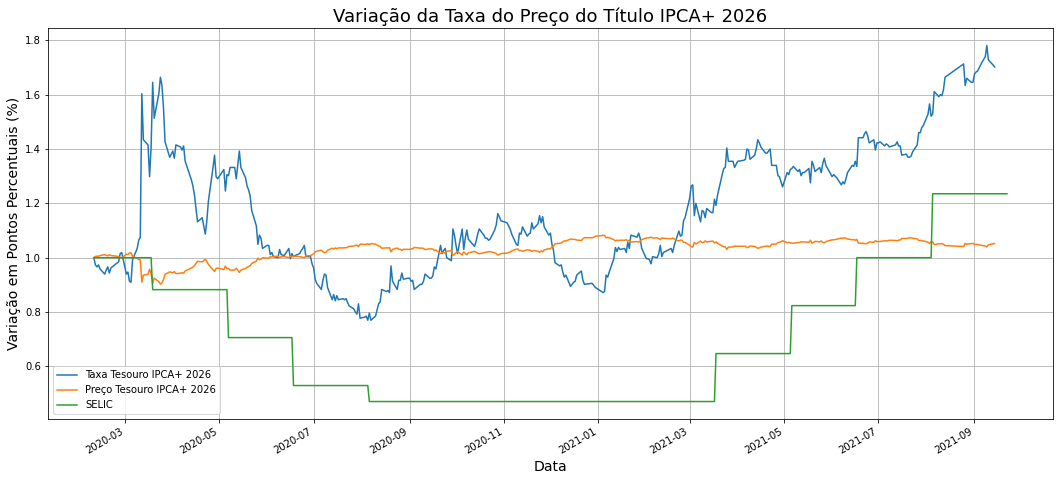

In [ ]:
(ipca2026['Taxa Compra Manha'] / ipca2026['Taxa Compra Manha'].iloc[0]).plot(label = 'Taxa Tesouro IPCA+ 2026');
(ipca2026['PU Compra Manha'] / ipca2026['PU Compra Manha'].iloc[0]).plot(label = 'Preço Tesouro IPCA+ 2026');
(selic_meta_ipca2026['selic_ano'] / selic_meta_ipca2026['selic_ano'].iloc[0]).plot(label = 'SELIC');
plt.title('Variação da Taxa do Preço do Título IPCA+ 2026', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais (%)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

A taxa do IPCA+ 2026 se mostrou muito menos valátil do que o título anterior. O motivo disso se dá pela indexação, a taxa não precisa aumentar à medida que o IPCA aumenta. Em compensação o preço do título vem subindo desde o início desse ano. Um motivo para isso, pode ser o aumento da inflação. Que aumentando tanto o numerador quanto o denominador a razão entre ele ficaria constante.

The IPCA+ 2026 rate proved to be much less valuable than the previous title. The reason for this is indexation, the rate does not need to increase as the IPCA increases. On the other hand, the price of the title has been rising since the beginning of this year. One reason for this could be the increase in inflation. That by increasing both the numerator and the denominator the ratio between them would remain constant.

##4.3 - Comparação

4.3 - Bonds comparison

###A) Inflação Projetada pelo Tesouro (Pré-Fixado 2026 menos IPCA + 2026)

A) Projected Inflation by the Treasury (Pré-Fixado 2026 Minus IPCA + 2026)

In [ ]:
pre2026 = titulos.loc[('Tesouro Prefixado', '2026-01-01')]
pre2026_manha = pre2026['Taxa Compra Manha']

In [ ]:
ipca2026 = titulos.loc[('Tesouro IPCA+', '2026-08-15')]
ipca2026_manha = ipca2026['Taxa Compra Manha']

In [ ]:
ipca_dif = pre2026_manha - ipca2026_manha
df_ipca_dif = pd.DataFrame(ipca_dif)

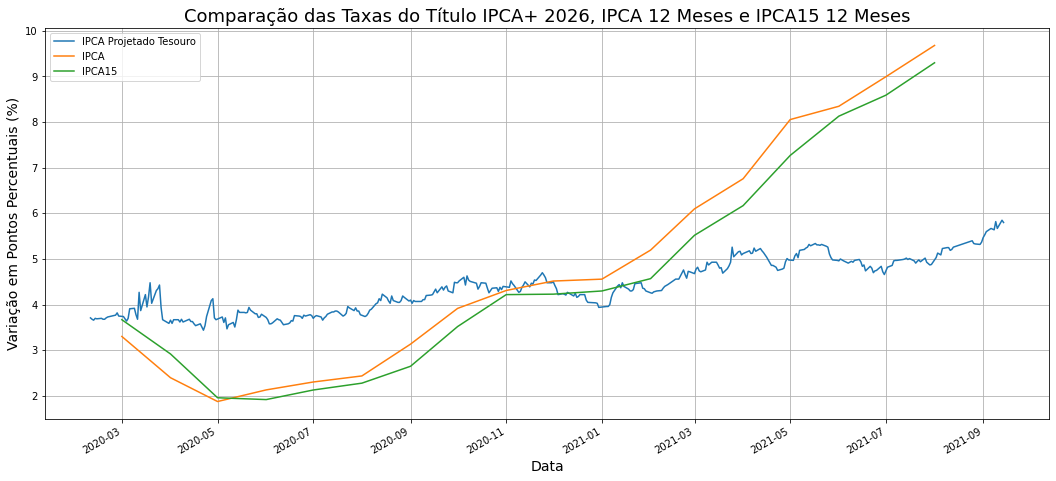

In [ ]:
df_ipca_dif['Taxa Compra Manha'].plot(label = 'IPCA Projetado Tesouro')
ipca_ipca2026['12meses_ipca'].plot(label = 'IPCA');
ipca15_ipca2026['12meses_ipca15'].plot(label = 'IPCA15');
plt.title('Comparação das Taxas do Título IPCA+ 2026, IPCA 12 Meses e IPCA15 12 Meses', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais (%)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
df = pd.merge(df_ipca_dif, ipca_ipca2026, left_index = True, right_index = True)
df = pd.merge(df, ipca15_ipca2026, left_index = True, right_index = True)
df[['Taxa Compra Manha', '12meses_ipca', '12meses_ipca15']].corr()

,Taxa Compra Manha,12meses_ipca,12meses_ipca15
Taxa Compra Manha,1.000000,0.879622,0.845172
12meses_ipca,0.879622,1.000000,0.992059
12meses_ipca15,0.845172,0.992059,1.000000


A diferença entre as taxas de juros dos títulos mostra a projeção de inflação do tesouro. Ela mostra um aumento devagar, porém constante. Além disso, podemos observar que o crescimento da taxa projetada pelo tesouro é muito mais morosa do que a real divulgada pelo IBGE.

The difference between bond interest rates shows the treasury's inflation projection. It is a slow but steady increase. In addition, we can observe that the growth of the rate projected by the treasury is much slower than the real one published by the IBGE.

###B) Comparação Taxas

B) Rate Comparison

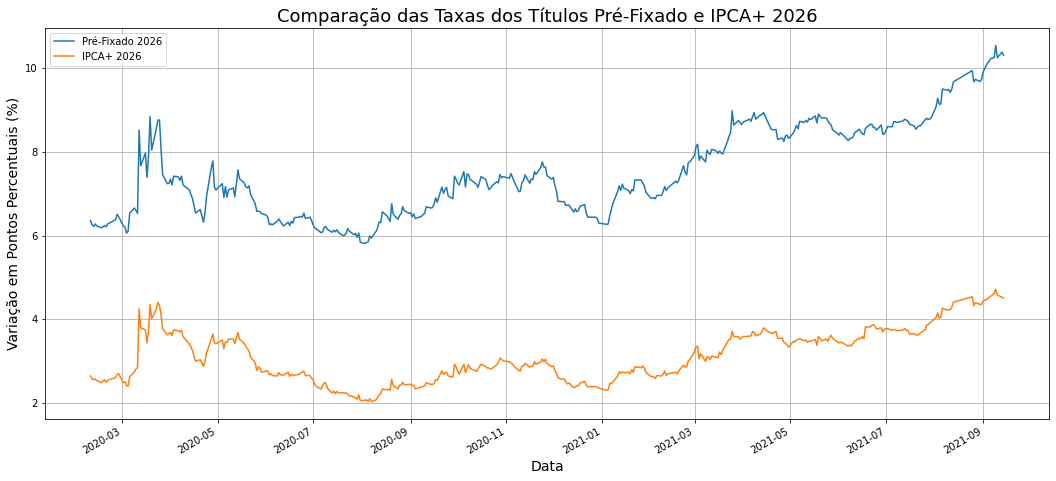

In [ ]:
pre2026['Taxa Compra Manha'].plot(label = 'Pré-Fixado 2026');
ipca2026['Taxa Compra Manha'].plot(label = 'IPCA+ 2026');
plt.title('Comparação das Taxas dos Títulos Pré-Fixado e IPCA+ 2026', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais (%)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

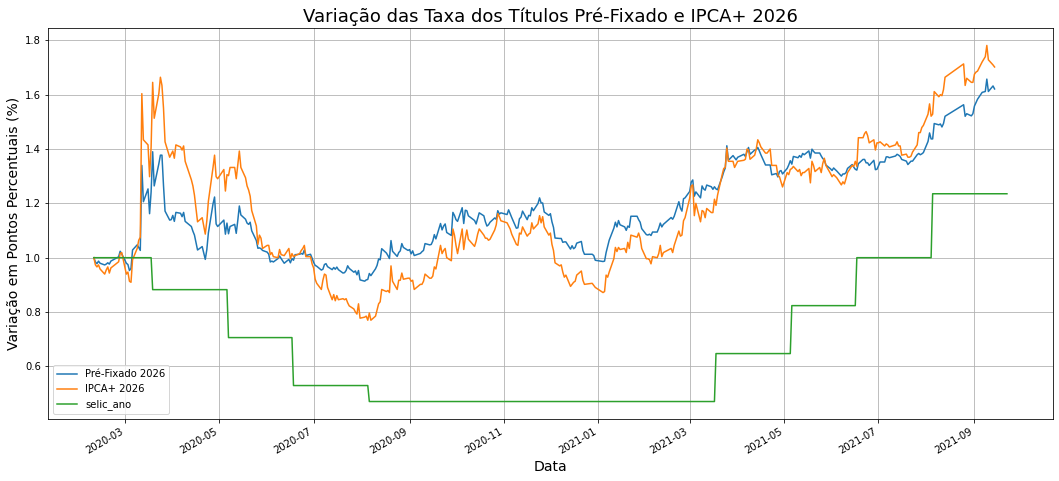

In [ ]:
(pre2026['Taxa Compra Manha'] / pre2026['Taxa Compra Manha'].iloc[0]).plot(label = 'Pré-Fixado 2026');
(ipca2026['Taxa Compra Manha'] / ipca2026['Taxa Compra Manha'].iloc[0]).plot(label = 'IPCA+ 2026');
#(selic_meta_ipca2026['selic_ano'] / selic_meta_ipca2026['selic_ano'].iloc[0]).plot();
plt.title('Variação das Taxa dos Títulos Pré-Fixado e IPCA+ 2026', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Pontos Percentuais (%)', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
df = pd.merge(ipca2026, pre2026, left_index = True, right_index = True)
df[['Taxa Compra Manha_x', 'Taxa Compra Manha_y']].corr()

,Taxa Compra Manha_x,Taxa Compra Manha_y
Taxa Compra Manha_x,1.000000,0.915146
Taxa Compra Manha_y,0.915146,1.000000


Quando analisamos as taxas em relação a sua taxa inicial, observamos que seu comportamento é bem parecido. Nota-se 3 períodos de comportamento da taxa: o primeiro de forte volatilidade (no segundo trimestre de 2020, quando a OMS decretou pandemia);  o segundo de crescimento gradual e queda da taxa (na segunda parte de 2020); e o terceiro de forte crescimento das taxas (desde o início do ano).

When we analyze rates against their initial rate, we see that their behavior is very similar. There are 3 periods: the first of high volatility (in the second quarter of 2020, when the WHO decreed a pandemic); the second of gradual growth and stronge fall rate (in the second part of 2020); and the third with strong rate growth (since the beginning of the year).

###C) Comparação Preços

C) Price Comparison

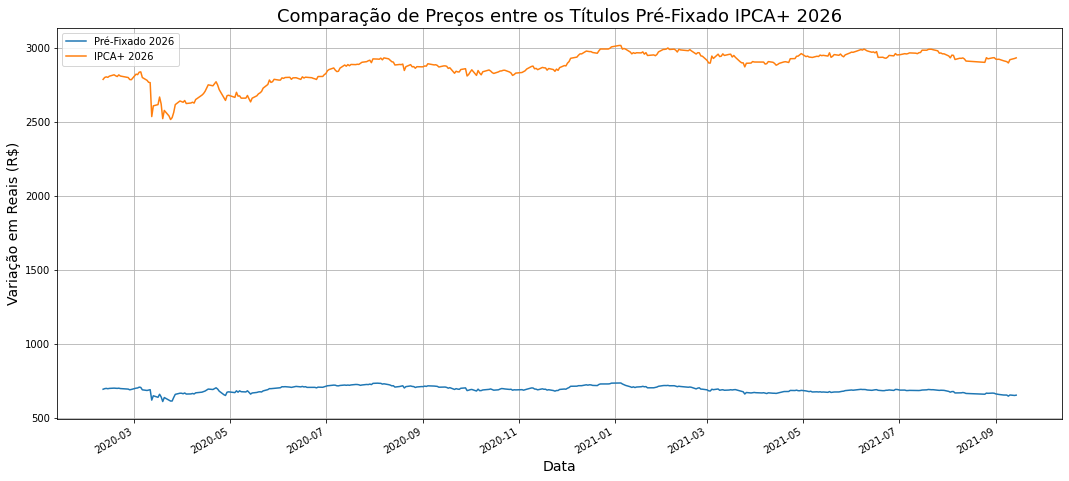

In [ ]:
pre2026['PU Compra Manha'].plot(label = 'Pré-Fixado 2026')
ipca2026['PU Compra Manha'].plot(label = 'IPCA+ 2026')
plt.title('Comparação de Preços entre os Títulos Pré-Fixado IPCA+ 2026', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Reais (R$)', fontsize = 14)
plt.legend()
plt.grid()
plt.show();

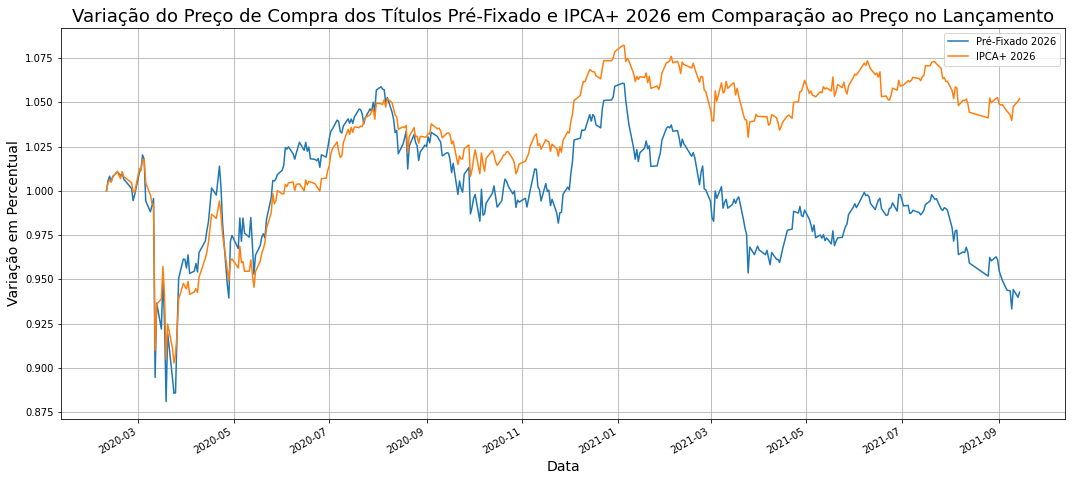

In [ ]:
(pre2026['PU Compra Manha'] / pre2026['PU Compra Manha'].iloc[0]).plot(label = 'Pré-Fixado 2026')
(ipca2026['PU Compra Manha'] / ipca2026['PU Compra Manha'].iloc[0]).plot(label = 'IPCA+ 2026')
plt.title('Variação do Preço de Compra dos Títulos Pré-Fixado e IPCA+ 2026 em Comparação ao Preço no Lançamento', fontsize = 18)
plt.xlabel('Data', fontsize = 14)
plt.ylabel('Variação em Percentual', fontsize = 14)
plt.legend()
plt.grid()
plt.show();

Quando analisamos os preços, temos um movimento quase igual até o final de 2020. A partir disso, os preços começa a se separar. Isso coincide com o aumento da inflação, impactando no título pré-fixado. Em vista de tudo exposto, a melhor opção entre os dois títulos seria o IPCA+ 2026, pois protege seu patrimônio do aumento da inflação e ainda te remunera com uma taxa real superior a 4% ao ano. Mesmo com um preço superior.

When we analyze prices, we have a movement that is almost the same as at the end of 2020. After that, prices start to separate. This coincides with the increase in information, impacting the pre-fixed bond. In view of all the above, the best option between the two securities would be the IPCA + 2026, as it protects your assets from the increase in information and is also remunerated at a real rate higher than 4% per year. Even at a higher price.